# Logistic Regression

In this exercise, we will be implementing a logistic regression model to predict whether a student gets admitted inot a university. Provided, is a dataset that has the applicant's scores on two exams and the admissions decision. First, lets load in the dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
np.seterr(divide = 'ignore', invalid='ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
data = pd.read_csv('ex2data1.txt', names=['exam_1_score', 'exam_2_score', 'admitted'])
data.head()

,exam_1_score,exam_2_score,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Now that we have our data loaded in, lets plot it and get a nice visualization of the data that we are working with

Text(0, 0.5, 'Exam 2 Score')

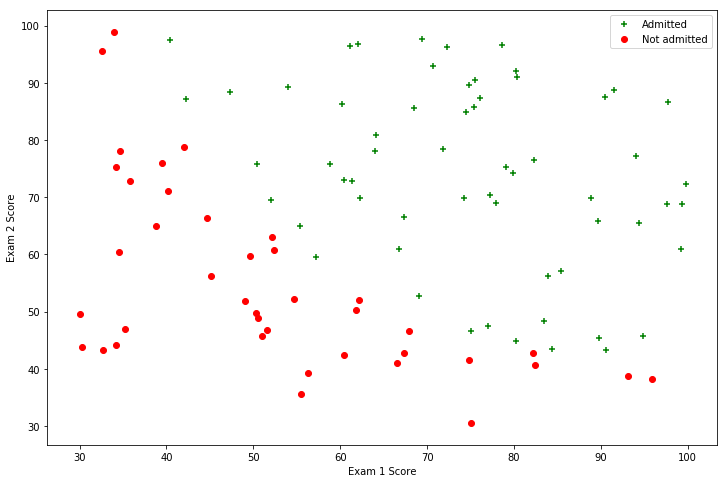

In [3]:
admitted = data[data['admitted'] == 1]
not_admitted = data[data['admitted'] == 0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(admitted['exam_1_score'], admitted['exam_2_score'], marker='+', color="green", label="Admitted")
ax.scatter(not_admitted['exam_1_score'], not_admitted['exam_2_score'], marker='o', color='red', label="Not admitted")
ax.legend()

plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')

Before starting with the actual cost function, we have to first set up the sigmoid function. The sigmoid function is defined as: 
$$ g(z) = \frac{1}{1 + e^{-z}} $$
and our hypothesis is defined as: 
$$ h_\Theta (x) = g(\theta^Tx) $$

In [4]:
def sigmoid(x):
    return 1/(1 + np.e**(-x))

Now that we implemented the sigmoid function, let's move onto implementing the cost function and gradient for linear regression

In [5]:
def cost(theta, X, y):
    m,n = X.shape
    theta = np.reshape(theta, (3,1))
    h = sigmoid(X @ theta)
    inner = -y*np.log(h)-(1-y)*np.log(1-h)
    return inner.sum()/m

In order to test out our new cost function, we first need to set up our data.

In [6]:
data.insert(0, 'ones', 1)

In [7]:
X = data.iloc[:, 0:len(data.columns)-1]
X.head()

,ones,exam_1_score,exam_2_score
0,1,34.623660,78.024693
1,1,30.286711,43.894998
2,1,35.847409,72.902198
3,1,60.182599,86.308552
4,1,79.032736,75.344376


In [8]:
y = data.iloc[:, len(data.columns)-1: len(data.columns)]
y.head()

,admitted
0,0
1,0
2,0
3,1
4,1


In [9]:
X = np.asarray(X)
y = np.asarray(y)
theta = np.array([0,0,0])
display(X.shape, y.shape, theta.shape)

(100, 3)

(100, 1)

(3,)

Let's test out our cost function. Below you can see, with initial values of theta, the cost is about 0.693

In [10]:
cost(theta, X, y)

0.6931471805599453

In order to train our logistic regression model, we also need a gradient descent function. We are going to feed both the cost function and the gradient descent function into the scipy function [fmin_bfgs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html), a python equivalent to `fminunc` in the Coursera course

In [11]:
def gradient(theta, X, y):
    m,n = X.shape
    theta = np.reshape(theta, (3,1))
    error = sigmoid(X @ theta) - y # 100x3 * 3x1 = 100x1
    inside = X.T @ error # 3x100 * 100x1 = 3x1
    return inside.flatten()/m

In [12]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

In [13]:
result = opt.fmin_bfgs(cost, theta, fprime=gradient, args=(X, y))
optimal_theta = result

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31


As you can see, after using fmin_bfgs, the cost when using the optimal parameters is about 0.203. Below is a graph of what the decision boundary looks like when using the optimal parameters. 

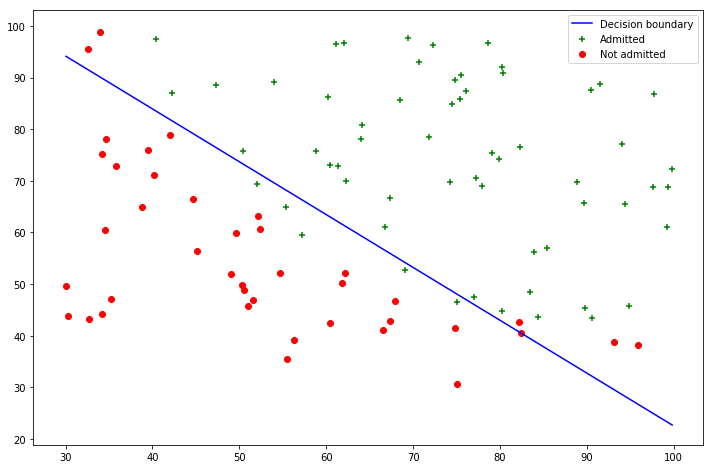

In [14]:
x = np.linspace(data['exam_1_score'].min(), data['exam_1_score'].max(), 100)
f = (-1/optimal_theta[2])*(optimal_theta[1]*x + optimal_theta[0])

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(admitted['exam_1_score'], admitted['exam_2_score'], marker='+', color="green", label="Admitted")
ax.scatter(not_admitted['exam_1_score'], not_admitted['exam_2_score'], marker='o', color='red', label="Not admitted")
ax.plot(x, f, 'b', label="Decision boundary")
ax.legend()

Using the optimal parameters, we can predict that a student with an exam 1 score of 45 and an exam score of 85 has an admission probability of 0.776

In [15]:
probability = sigmoid(optimal_theta[0] + optimal_theta[1]*(45) + optimal_theta[2]*(85))
probability

0.776290724058894

To extend this a bit further, we can also define a function predict() that will produce "1" or "0" predictions given a dataset and a learned parameter vector $\theta$. Using this function, we can find the training accuracy of our classifier by computing the percentage of examples it got correct

In [16]:
# X is 100x3
# theta is 1x3
def predict(X, theta): 
    m,n = X.shape
    theta = np.reshape(theta, (n,1)) # theta is now nx1
    probability = sigmoid(X @ theta)
    for i in range(np.size(probability, 0)):
        if probability[i][0] > 0.5:
            probability[i][0] = 1
        else: 
            probability[i][0] = 0
    return probability.astype(int)

In [17]:
def trainingAcc(actual, predicted):
    m = np.size(actual, 0)
    numCorrect = 0
    for i in range(m):
        if actual[i][0] == predicted[i][0]:
            numCorrect += 1
    return numCorrect/m

We end up getting a training accuracy of 89%!!!

In [18]:
trainingAcc(y, predict(X, optimal_theta))

0.89

# Regularized Logistic Regression

In this part of the exercise, we will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). We are provided a dataset of test results on past microships which we can use to build a logistic regression model and predict whether microchips should be accepted or rejected.

Let's first load in the dataset.

In [19]:
data = pd.read_csv('ex2data2.txt', names=['test_1', 'test_2', 'accepted'])
data.head()

,test_1,test_2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Text(0, 0.5, 'Microchip Test 2')

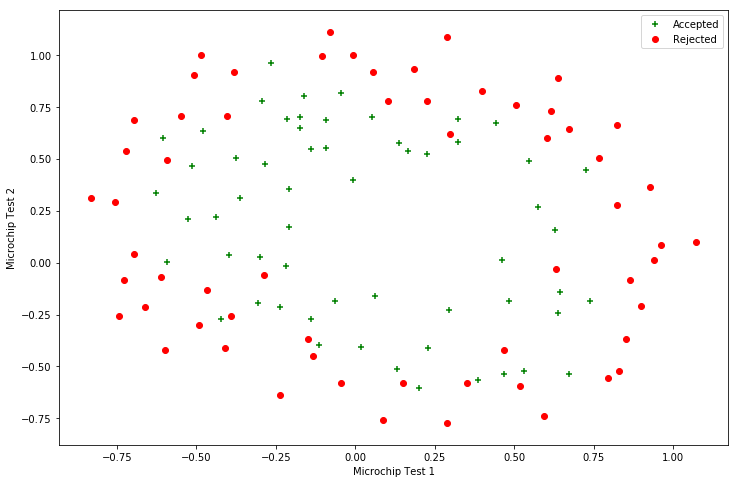

In [20]:
accepted = data[data['accepted'] == 1]
not_accepted = data[data['accepted'] == 0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(accepted['test_1'], accepted['test_2'], marker='+', color="green", label="Accepted")
ax.scatter(not_accepted['test_1'], not_accepted['test_2'], marker='o', color='red', label="Rejected")
ax.legend()

plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')

As we can see, this data will not fair well with a simple linear decision boundary. In order to accomodate this, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power. As a result, we will use our two features to get a 28-dimensional vector.

In [21]:
from sklearn.preprocessing import PolynomialFeatures

def mapFeature(X):
    poly = PolynomialFeatures(6)
    return poly.fit_transform(X)

In [22]:
X = data.iloc[:, 0:len(data.columns)-1]
X.head()

,test_1,test_2
0,0.051267,0.69956
1,-0.092742,0.68494
2,-0.213710,0.69225
3,-0.375000,0.50219
4,-0.513250,0.46564


In [23]:
y = data.iloc[:, len(data.columns)-1: len(data.columns)]
y.head()

,accepted
0,1
1,1
2,1
3,1
4,1


In [24]:
X = mapFeature(np.asarray(X))
y = np.asarray(y)
theta = np.zeros(np.size(X, 1))
display(X.shape, y.shape, theta.shape)

(118, 28)

(118, 1)

(28,)

In [25]:
learningRate = 1;

Now that we have X, y, and $\theta$ set up, we are ready to implement the cost function and gradient for regularized logistic regression. 

In [26]:
def costReg(theta, X, y, regParam):
    m,n = X.shape
    theta = np.reshape(theta, (n,1))
    h = sigmoid(X @ theta)
    inner = -y*np.log(h)-(1-y)*np.log(1-h)
    outer = inner.sum()/m
    reg = (regParam/(2*m))*(theta**2).sum()
    return outer + reg

In [27]:
def gradientReg(theta, X, y, regParam):
    m,n = X.shape
    theta = np.reshape(theta, (n,1)) # 28x1
    h = sigmoid(X @ theta)
    error = h - y # 118x1
    inside = X.T @ error # 28x118 * 118x1 = 28x1
    outer = inside/m
    reg_theta = theta.copy()
    reg_theta[0] = 0
    reg = (regParam/m) * reg_theta
    return (outer + reg).flatten()

In [28]:
costReg(theta, X, y, learningRate)

0.6931471805599454

Here, we are going to use the same fmin_bfgs function to get the optimal parameters for our cost function. 

In [29]:
result = opt.fmin_bfgs(costReg, theta, fprime=gradientReg, args=(X, y, learningRate))
optimal_theta = result

         Current function value: 0.535591
         Iterations: 25
         Function evaluations: 125
         Gradient evaluations: 113


In [30]:
trainingAcc(y, predict(X, optimal_theta))

0.8305084745762712

Text(0, 0.5, 'Microchip Test 2')

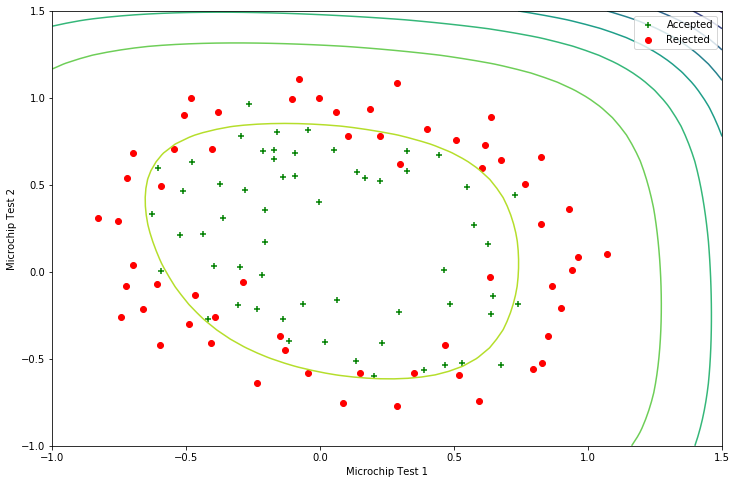

In [31]:
def map_feature(x1, x2):
    '''
    Maps the two input features to quadratic features.
    Returns a new feature array with more features, comprising of
    X1, X2, X1 ** 2, X2 ** 2, X1*X2, X1*X2 ** 2, etc...
    Inputs X1, X2 must be the same size
    '''
    x1.shape = (x1.size, 1)
    x2.shape = (x2.size, 1)
    degree = 6
    out = np.ones(shape=(x1[:, 0].size, 1))

    m, n = out.shape

    for i in range(1, degree + 1):
        for j in range(i + 1):
            r = (x1 ** (i - j)) * (x2 ** j)
            out = np.append(out, r, axis=1)

    return out

u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = (map_feature(np.array(u[i]), np.array(v[j])).dot(np.array(optimal_theta)))
z = z.T


# The above code for graphing the decision boundary is credited to Marcel Caraciolo


fig, ax = plt.subplots(figsize=(12,8))
ax.contour(u, v, z)
ax.scatter(accepted['test_1'], accepted['test_2'], marker='+', color="green", label="Accepted")
ax.scatter(not_accepted['test_1'], not_accepted['test_2'], marker='o', color='red', label="Rejected")
ax.legend()

plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')

We can finally plot the resulting decision boundary on the data! 

This marks the end of exercise 2.